# 0. Baseline 구축하기

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_fomat = 'retina'

In [25]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
data_dir = os.getenv("HOME") + '/aiffel/kaggle_kakr_housing/data/'
train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


# 1. 데이터 살펴보기

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도 
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [27]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

data.shape, sub.shape

((15035, 21), (6468, 20))

In [28]:
y = data['price']
data.drop('price', axis = 1, inplace = True)
data.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

## 데이터 불러오기 및 Feature Engineering

In [29]:
# 학습데이터와 테스트데이터 합치기
train_len = len(data)
data = pd.concat((data, sub), axis = 0)
print(len(data))

21503


<AxesSubplot:>

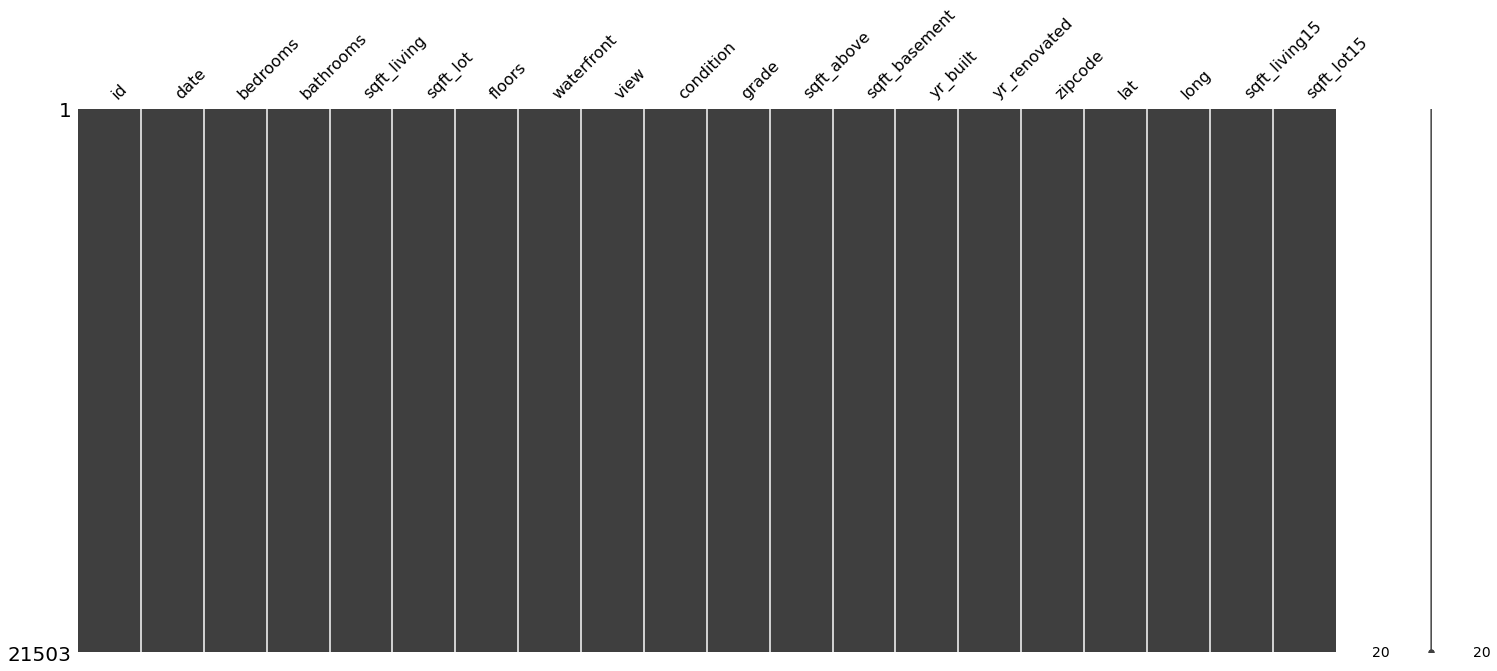

In [30]:
# 결측치 확인
msno.matrix(data)

In [31]:
data.isna().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

- 결측치 없음! 따로 제거하지 않아도 될듯 함

In [32]:
# id 컬럼 따로 저장하기 및 데이터에서 삭제
sub_id = data['id'][train_len: ]
data.drop('id', axis = 1, inplace = True)

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [33]:
# date 변환하기
data['date'] = data['date'].apply(lambda x: str(x[:6])).astype(int)
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 데이터 시각화

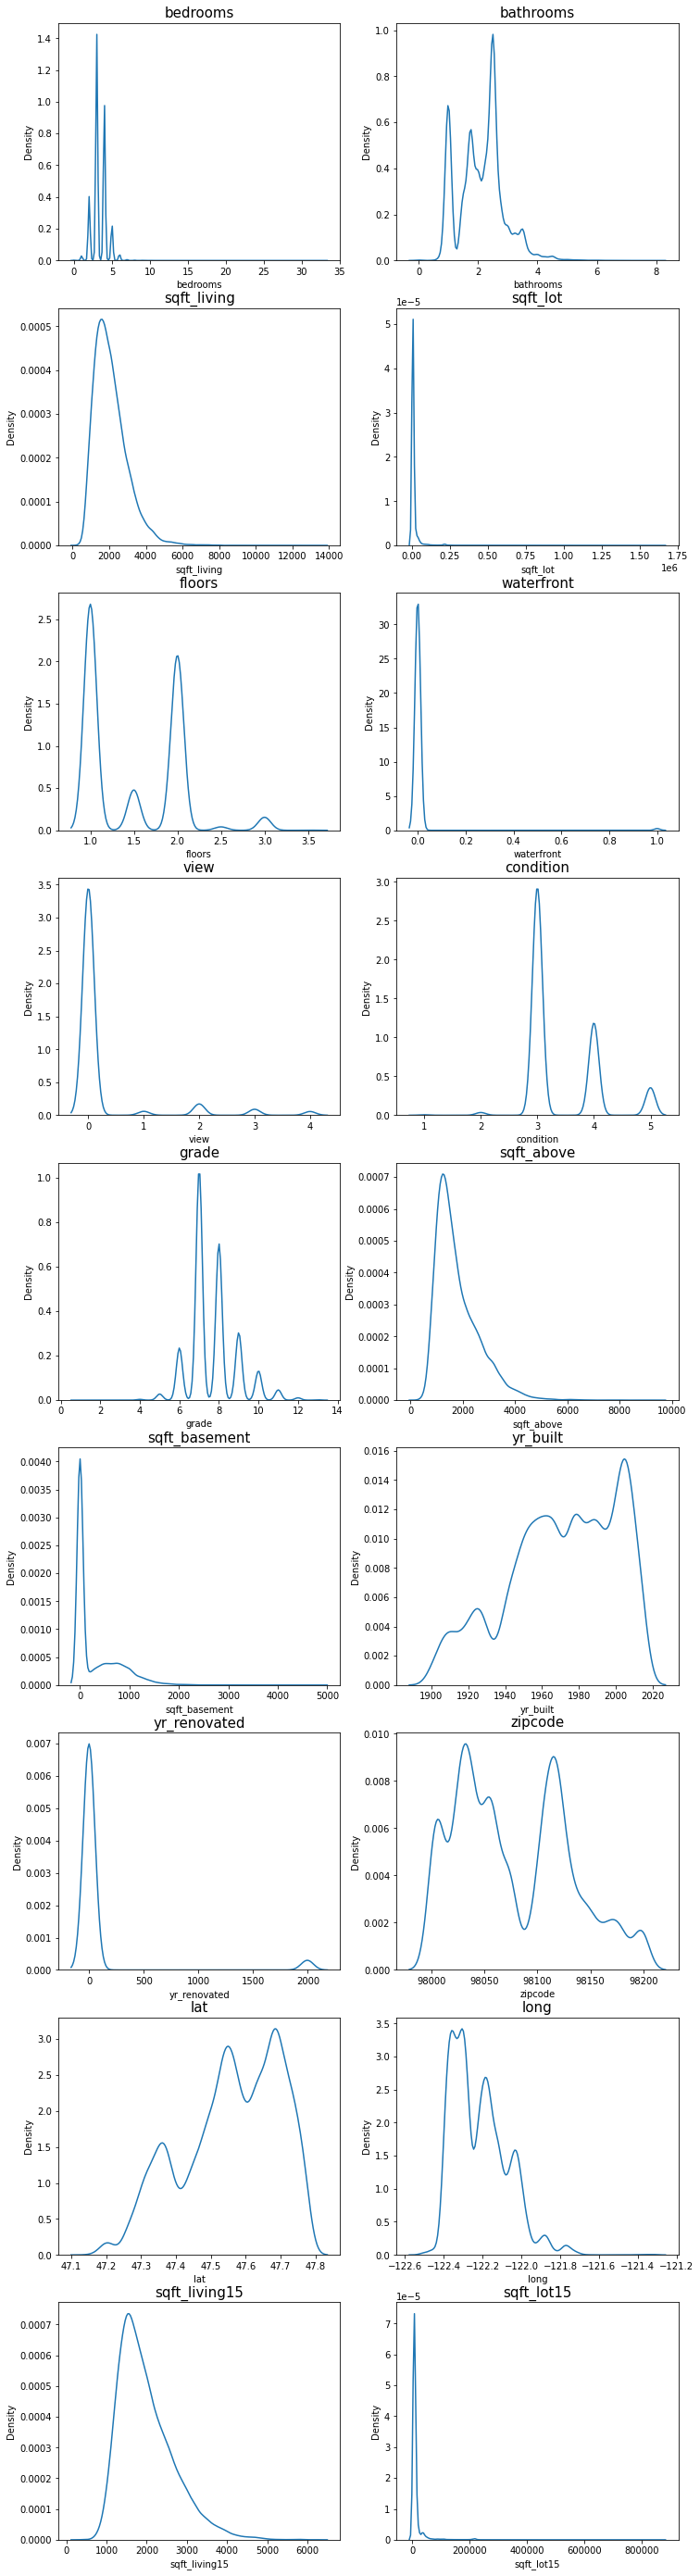

In [34]:
fig, ax = plt.subplots(9, 2, figsize= (12, 50))

count = 1
columns = data.columns

for row in range(9):
    for col in range(2):
        sns.kdeplot(data = data[columns[count]], ax = ax[row][col])
        ax[row][col].set_title(columns[count], fontsize = 15)
        count += 1
        if count == 19:
            break

In [35]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

data[skew_columns].head()

,bedrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,1.386294,7.074117,8.639588,7.074117,0.0,7.201171,8.639588
1,1.098612,6.647688,9.210440,6.647688,0.0,7.908755,8.995041
2,1.386294,7.427144,8.997271,7.427144,0.0,7.496097,8.923191
3,1.386294,7.447751,8.827615,7.447751,0.0,7.713785,8.827615
4,1.386294,6.966967,9.181118,6.966967,0.0,7.409136,9.181118


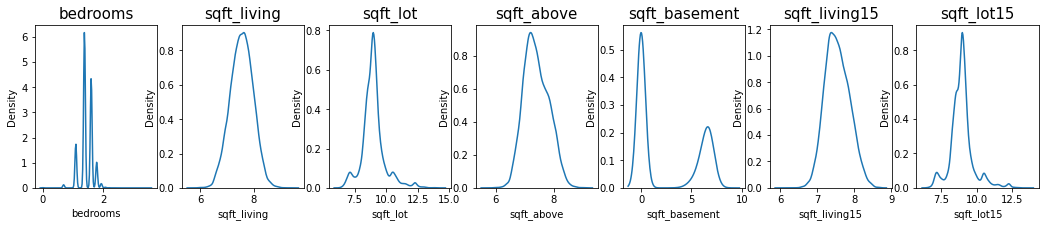

In [36]:
fig, ax = plt.subplots(1, 7, figsize = (18, 3))

for c in range(7):
    sns.kdeplot(data = data[skew_columns[c]], ax = ax[c])
    ax[c].set_title(skew_columns[c], fontsize = 15)

- skewed 되었던 columns의 분포가 고르게 잘 나타남 

<AxesSubplot:>

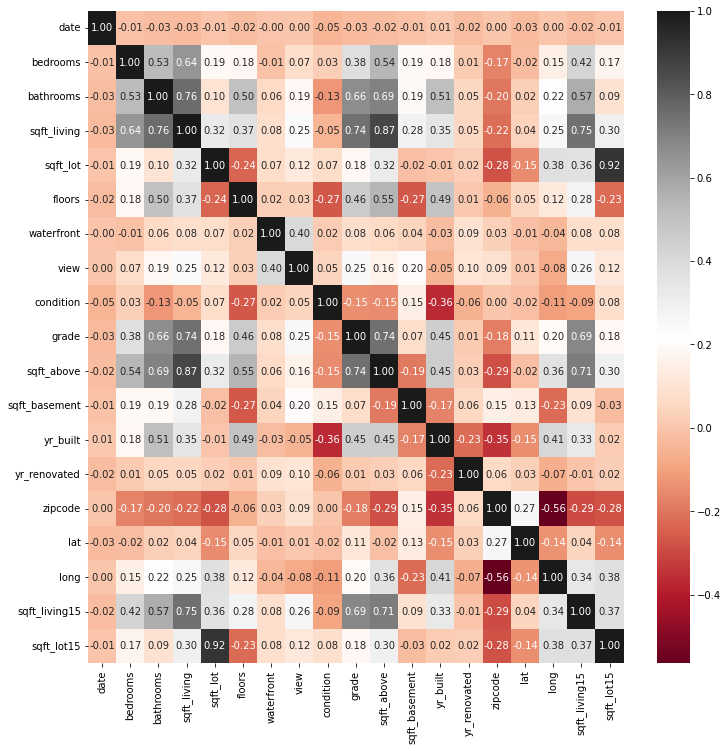

In [37]:
# 상관계수 찍어보기

plt.figure(figsize = (12, 12))
sns.heatmap(data = data.corr(), annot = True, cmap = 'RdGy', fmt = '.2f')

- sqft_lot 과 sqft_lot15 의 상관계수는 0.92로 강한 상관관계를 가짐
- zipcode는 lat보다는 lon값과 더 강한 상관관계가 있는 듯

**시도해보면 좋을 것들**
- zip 코드값 제외하고 수행하기
- PCA로 차원축소 후 모델학습 해보기 

# 모델 학습

In [38]:
sub = data.iloc[train_len:, :]
X = data.iloc[:train_len, :]

sub.shape, X.shape

((6468, 19), (15035, 19))

In [39]:
y_log1p = np.log1p(y)

## 1차 시도 - Baseline Model, Raw Data 

In [40]:
random_state = 2020

gboost = GradientBoostingRegressor(random_state = random_state)
xgboost = XGBRegressor(random_state = random_state)
lightgbm = LGBMRegressor(random_state= random_state)
rdforest = RandomForestRegressor(random_state= random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [41]:
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse**0.5
    return rmse

def get_scores(models, train, y_log1p):
    df = {}
    X_train, X_val, y_train, y_val = train_test_split(X, y_log1p, random_state = random_state)
    
    for model in models:
        model_name = model.__class__.__name__
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        df[model_name] = rmse(y_val, y_pred)
    
    score_df = pd.DataFrame(df, index = ['RMSE']).T.sort_values('RMSE', ascending = False)
    
    return score_df
        

In [42]:
get_scores(models, X, y_log1p)

,RMSE
GradientBoostingRegressor,0.183321
RandomForestRegressor,0.178539
XGBRegressor,0.169081
LGBMRegressor,0.164581


## 2차 시도 - GridSearchCV

In [43]:
from sklearn.model_selection import GridSearchCV

In [57]:
param_grid = {
    gboost.__class__.__name__:{
        'n_estimators': [50, 100],
        'learning_rate': [0.01],
        'max_depth': [3, 5, 7, 10]
    },
    rdforest.__class__.__name__:{
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10]
    },
    lightgbm.__class__.__name__:{
        'n_estimators': [50, 100],
        'learning_rate': [0.01],
        'max_depth': [3, 5, 7, 10]
    },
    xgboost.__class__.__name__:{
        'n_estimators': [50, 100],
        'learning_rate': [0.01],
        'max_depth': [3, 5, 7, 10]
    }
}

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X, y_log1p, test_size = 0.2, random_state = 2020)

In [58]:
best_models = {}

for model in models:
    model_name = model.__class__.__name__
    print('GridSearchCV for ', model_name,' is running...')
    grid_model = GridSearchCV(model, param_grid = param_grid[model_name], scoring = 'neg_mean_squared_error', cv = 5, verbose = -1, n_jobs = 5)
    
    grid_model.fit(X_train, y_train)
    
    best_models[model_name] = grid_model.best_estimator_
    print(f'best_score of {model_name}: {grid_model.best_score_}')
    print(f'best_params of {model_name}: {grid_model.best_estimator_}')


GridSearchCV for  GradientBoostingRegressor  is running...
best_score of GradientBoostingRegressor: -0.06994357102537627
best_params of GradientBoostingRegressor: GradientBoostingRegressor(learning_rate=0.01, max_depth=10, random_state=2020)
GridSearchCV for  XGBRegressor  is running...


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

best_score of XGBRegressor: -21.229953007624168
best_params of XGBRegressor: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
GridSearchCV for  LGBMRegressor  is running...
best_score of LGBMRegressor: -0.08069519535635895
best_params of LGBMRegressor: LGBMRegressor(learning_rate=0.01, max_depth=10, random_state=2020)
GridSearchCV for  RandomForestRegressor  is running...
best_score of RandomForestRegressor: -0.035217337636964455
best_params of RandomForestRegressor: RandomF

In [83]:
# 우선 RandomForest max_depth =10, min_samples_split = 5 로 pred값 만들기..
rf_cv = RandomForestRegressor(max_depth = 10, min_samples_split = 5, random_state = 2020)
rf_cv.fit(X, y_log1p)
pred = rf_cv.predict(sub)
pred = np.expm1(pred)

In [85]:
submission_df = pd.read_csv(join(data_dir, 'sample_submission.csv'))
submission_df.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [86]:
submission_df['price']= pred
submission_df.head()

,id,price
0,15035,4.700637e+05
1,15036,4.939048e+05
2,15037,1.289294e+06
3,15038,3.039323e+05
4,15039,3.185466e+05


In [87]:
submission_df.to_csv('./submission_01.csv', index = False)

## 3차 시도 - PCA 수행하기

In [60]:
# pca = PCA()
# pca.fit(X)

# explained_variance = np.cumsum(pca.explained_variance_ratio_)
# n_components = np.argmax(explained_variance >= 0.90) + 1
# print(f'90% 이상의 분산을 설명하기 위해 필요한 주성분 개수: {n_components}')

90% 이상의 분산을 설명하기 위해 필요한 주성분 개수: 1


In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
pca.fit(X)
X_pca = pca.transform(X)
X_pca.shape

(15035, 5)

In [81]:
pca.explained_variance_ratio_.sum()

0.9999740379702862

- 99%의 데이터 설명률을 나타냄

In [76]:
X_tr_pca, X_val_pca, y_train, y_val = train_test_split(X_pca, y_log1p, test_size = 0.2, random_state = 2020)